In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

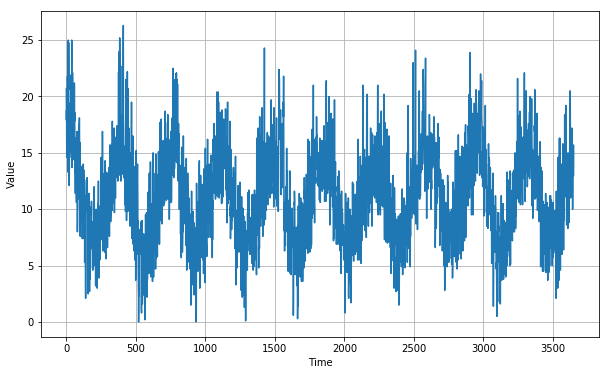

In [4]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i, row in enumerate(reader):
    time_step.append(i)
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = np.array(time_step[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time_step[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 60, kernel_size = 5, strides = 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 501ms/step - loss: 23.6450 - mae: 24.1510
Epoch 2/100
10/10 [==============================] - 1s 147ms/step - loss: 23.4360 - mae: 23.9335
Epoch 3/100
10/10 [==============================] - 1s 147ms/step - loss: 23.1232 - mae: 23.6011
Epoch 4/100
10/10 [==============================] - 1s 149ms/step - loss: 22.7011 - mae: 23.1949
Epoch 5/100
10/10 [==============================] - 1s 143ms/step - loss: 22.2113 - mae: 22.7260
Epoch 6/100
10/10 [==============================] - 1s 142ms/step - loss: 21.7035 - mae: 22.1935
Epoch 7/100
10/10 [==============================] - 1s 146ms/step - loss: 21.0882 - mae: 21.5903
Epoch 8/100
10/10 [==============================] - 1s 146ms/step - loss: 20.4265 - mae: 20.9085
Epoch 9/100
10/10 [==============================] - 1s 148ms/step - loss: 19.6608 - mae: 20.1358
Epoch 10/100
10/

KeyboardInterrupt: 

[1e-08, 0.0001, 0, 10]

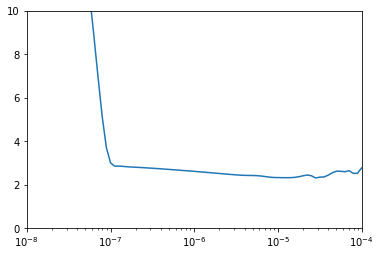

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 10])

In [51]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(62, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
20/20 [==============================] - 8s 395ms/step - loss: 8.6416 - mae: 9.3689
Epoch 2/200
20/20 [==============================] - 5s 263ms/step - loss: 2.6841 - mae: 3.1741
Epoch 3/200
20/20 [==============================] - 5s 263ms/step - loss: 2.1294 - mae: 2.5965
Epoch 4/200
20/20 [==============================] - 5s 265ms/step - loss: 1.8882 - mae: 2.3457
Epoch 5/200
20/20 [==============================] - 5s 265ms/step - loss: 1.8074 - mae: 2.2626
Epoch 6/200
20/20 [==============================] - 5s 263ms/step - loss: 1.7663 - mae: 2.2189
Epoch 7/200
20/20 [==============================] - 5s 265ms/step - loss: 1.7539 - mae: 2.2056
Epoch 8/200
20/20 [==============================] - 5s 264ms/step - loss: 1.7347 - mae: 2.1858
Epoch 9/200
20/20 [==============================] - 5s 264ms/step - loss: 1.7176 - mae: 2.1679
Epoch 10/200
20/20 [==============================] - 5s 269ms/step - loss: 1.7066 - mae: 2.1564
Epoch 11/200
20/20 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

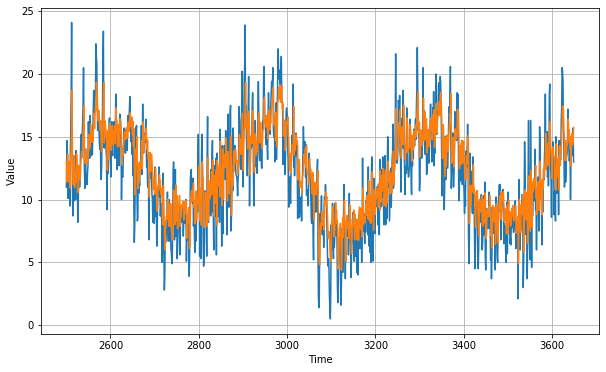

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8423259

In [61]:
print(rnn_forecast)

[12.991883 11.395994 12.420638 ... 14.350714 14.552343 15.739719]
